# MIS 583 Assignment 3: Flower Classfication

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm XXX, XXXXXXXXXX

## Flower Classification

Image classification is a core and fundamental task in computer vision.

In the assignment, you will implement a multi-class image classifier to recognize flowers.

You will design and train a deep convolutional network from scratch to predict the class label of a flower image. This will help you gain experience with network design and get more familiar with PyTorch.

**Please note that you’re not allowed to use a pre-trained model.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa) to join the competition.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.6.0`

In [1]:
!python --version
!pip freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

This dataset contains 4323 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes: 
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Get Data

請先到共用雲端硬碟將檔案`flower_data.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1rTfeCpKXoQXI978QiTWC-AI1vwGvd5SU/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip Data

解壓縮 `flower_data.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train`的圖片3112張，`val`的圖片778章，`test`的圖片433張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [3]:
!unzip -qq ./drive/My\ Drive/Colab\ Notebooks/data/flower_data.zip

## Loading the dataset


### Custom dataset

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [4]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['file_path'])
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):

        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))

        return data, label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

Pytorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/docs/stable/torchvision/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

(**Slide.07 page.49**)

In [5]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
resize_dim= 256
image_dim = 224
transforms_train = transforms.Compose([
          transforms.Resize((resize_dim, resize_dim)),
          transforms.RandomCrop(image_dim),
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomRotation((0, 360)),
          transforms.ColorJitter(0.1, 0.2, 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(inplace=True, scale=(0.01, 0.23)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
          transforms.Resize((resize_dim, resize_dim)),
          transforms.CenterCrop((image_dim, image_dim)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [6]:
dataset_train = FlowerData('./data/train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('./data/val.csv', mode='train', transform=transforms_train)
dataset_test = FlowerData('./data/test.csv', mode='test', transform=transforms_test)

In [7]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 3112 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [9]:
import torch.nn as nn 
import torch.nn.functional as F

class Bottleneck(nn.Module):
		'''The residual block with bottleneck'''
		expansion = 4
		def __init__(
				self,
				in_channels: int,
				out_channels: int,
				stride: int = 1,
				groups: int = 1,
				base_width: int = 64,
				norm_layer = nn.BatchNorm2d,
		):
				super(Bottleneck, self).__init__()
				neck_width = int(out_channels*(base_width/64.))*groups
				self.seq = nn.Sequential(
						nn.Conv2d(in_channels, neck_width, 1, bias=False),
						norm_layer(neck_width),
						nn.ReLU(inplace=True),
						nn.Conv2d(neck_width, neck_width, 3, padding=1, stride=stride, groups=groups, bias=False),
						norm_layer(neck_width),
						nn.ReLU(inplace=True),
						nn.Conv2d(neck_width, out_channels*self.expansion, 1, bias=False),
						norm_layer(out_channels*self.expansion),
				)
				self.bypass = nn.Sequential(
						nn.Conv2d(in_channels, out_channels*self.expansion, 1, stride=stride, bias=False),
						norm_layer(out_channels*self.expansion)
				)
		def forward(self, x):
				out = self.seq(x)
				x = self.bypass(x)
				#residual
				out += x
				F.relu_(out)
				return out

class Your_CNN_Model(nn.Module): 
		'''ResNet50'''
		def __init__(
				self, 
				blocks_list = [3, 4, 6, 3],
				num_classes: int = 5,
				groups: int = 1, 
				base_width: int = 64, 
				norm_layer = nn.BatchNorm2d
		):
				super().__init__()
				########################################################################
				#     TODO: use nn.xxx method to generate a CNN model part             #
				########################################################################
				self.in_channels = base_width
				self.groups = groups
				self.base_width = base_width
				self.pre_layer = nn.Sequential(
						nn.Conv2d(3, self.in_channels, 7, stride=2, padding=3, bias=False),
						norm_layer(self.in_channels),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(3, stride=2, padding=1),
				)
				self.layer1 = self._make_layer(self.base_width, blocks_list[0])
				self.layer2 = self._make_layer(self.base_width*2, blocks_list[1], stride=2)
				self.layer3 = self._make_layer(self.base_width*4, blocks_list[2], stride=2)
				self.layer4 = self._make_layer(self.base_width*8, blocks_list[3], stride=2)
				self.fc = nn.Sequential(
						nn.Linear(base_width*8*Bottleneck.expansion, 1000),
						nn.Dropout(inplace = True),
						nn.ReLU(inplace = True),
						nn.Linear(1000, num_classes),
				)
				#initialize parameters
				for m in self.modules():
						if isinstance(m, nn.Conv2d):
								nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
						elif isinstance(m, nn.BatchNorm2d):
								nn.init.constant_(m.weight, 1)
								nn.init.constant_(m.bias, 0)
				########################################################################
				#                           End of your code                           #
				########################################################################

		def forward(self, x): 
				if not isinstance(x, torch.Tensor):
						x = torch.Tensor(x)
				########################################################################
				#     TODO: forward your model and get output                          #
				########################################################################
				out = self.pre_layer(x)
				out = self.layer1(out)
				out = self.layer2(out)
				out = self.layer3(out)
				out = self.layer4(out)
				out = F.adaptive_avg_pool2d(out, (1, 1))
				out = torch.flatten(out, 1)
				out = self.fc(out)
				########################################################################
				#                           End of your code                           #
				########################################################################
				return out


		def _make_layer(self, out_channels, blocks, stride=1):
				'''helper function to create multiple blocks'''
				layers = []
				layers.append(Bottleneck(self.in_channels, out_channels, stride, self.groups, self.base_width))
				self.in_channels = out_channels*Bottleneck.expansion
				for _ in range(blocks-1):
						layers.append(Bottleneck(self.in_channels, out_channels, groups=self.groups, base_width=self.base_width))
				return nn.Sequential(*layers)

In [10]:
model = Your_CNN_Model()
model = model.cuda()
print(model)

Your_CNN_Model(
  (pre_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (seq): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
  

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [11]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.cuda()

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [12]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for i, data in enumerate(input_data, 0):
        images, labels = data[0].cuda(), data[1].cuda()
        
        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted = torch.max(out, 1)
        total_count += out.shape[0]
        acc_count += (predicted == labels).sum().item()
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [13]:
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            images, labels = data[0].cuda(), data[1].cuda()

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            out = model(images)
            loss = criterion(out, labels)
            
            _, predicted = torch.max(out, 1)
            total_count += out.shape[0]
            acc_count += (predicted == labels).sum().item()
            loss_list.append(loss.item())
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [14]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 10
log_interval = 2 # print acc and loss in per log_interval time
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

==================== Epoch 2 ====================
Train Acc: 0.338368 Train Loss: 1.519591
  Val Acc: 0.329049   Val Loss: 1.487152
==================== Epoch 4 ====================
Train Acc: 0.479434 Train Loss: 1.202422
  Val Acc: 0.510283   Val Loss: 1.265313
==================== Epoch 6 ====================
Train Acc: 0.487468 Train Loss: 1.131941
  Val Acc: 0.500000   Val Loss: 1.207926
==================== Epoch 8 ====================
Train Acc: 0.553663 Train Loss: 1.085414
  Val Acc: 0.496144   Val Loss: 1.443924
==================== Epoch 10 ====================
Train Acc: 0.575514 Train Loss: 1.040544
  Val Acc: 0.533419   Val Loss: 1.226884


#### Visualize accuracy and loss

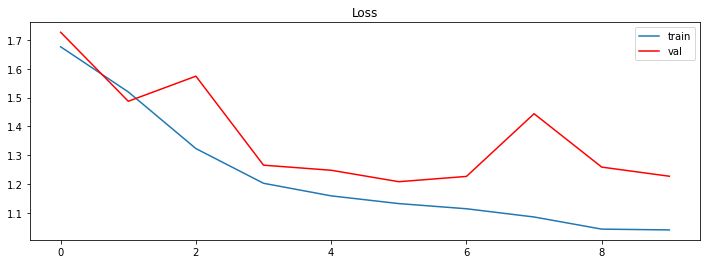

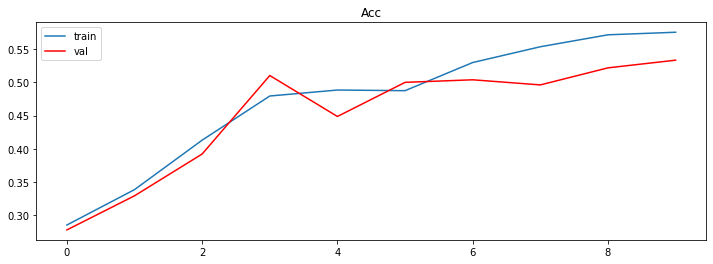

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

### Predict Result

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [16]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [17]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['Id', 'Category'])
    writer.writeheader()
    for result in output_csv:
        idx+=1
        writer.writerow({'Id':idx, 'Category':result})

# Keep trying and write report

持續調整模型、訓練方法、損失函數、優化器等，來訓練出更好的模型，並記錄使用不同參數得出的效果，以利後續 Report 的撰寫。

大家加油！

# Final boost
Concatenate training data with validation data to give the model a final boost

In [18]:
dataset_train = FlowerData('./data/train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('./data/val.csv', mode='train', transform=transforms_train)
dataset_test = FlowerData('./data/test.csv', mode='test', transform=transforms_test)

In [19]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", dataset_train.__len__()+dataset_val.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 3890 images in dataset_train.


In [20]:
from torch.utils.data import ConcatDataset
train_loader = DataLoader(ConcatDataset((dataset_train, dataset_val)), batch_size=128, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

In [21]:
max_epochs = 10
log_interval = 2

train_acc_list = []
train_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))

==================== Epoch 2 ====================
Train Acc: 0.593830 Train Loss: 1.012825
==================== Epoch 4 ====================
Train Acc: 0.592545 Train Loss: 1.016069
==================== Epoch 6 ====================
Train Acc: 0.613882 Train Loss: 0.971281
==================== Epoch 8 ====================
Train Acc: 0.628792 Train Loss: 0.926030
==================== Epoch 10 ====================
Train Acc: 0.644987 Train Loss: 0.883462


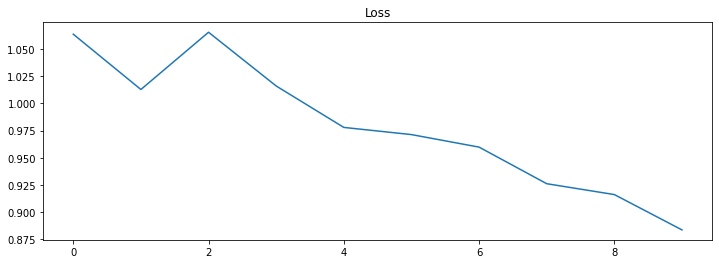

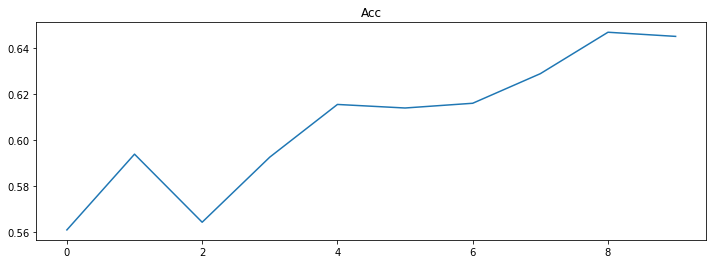

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.title('Acc')
plt.show()